## Sparkify churn prediction (ETL, EDA, and Feature Engineering)

In this notebook we outline the ETL and EDA parts (in loose order) of the Sparkify churn prediction project.
After importing the nessecary dependencies, creating a spark session and loading the data, we take a closer look at the data, perform some cleaning, do some transformation and some vizualizaion. Next we engineer the features. 

When this is done, we will have a cleaned, polished, and reusable dataset we can use to test and tune models on. 
So as a last step, we export our cleaned dataset to a parquet file for further processing in the next notebook.

In [1]:
# Import PySpark dependencies and obtain a spark session
import findspark

In [2]:
findspark.init()

In [3]:
findspark.find()

'C:\\dev\\runtimes\\spark-2.4.6-bin-hadoop2.7\\'

In [4]:
import pyspark

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [6]:
# Imports used for analysis, vizualisation, transformation and feature extraction
import pandas as pd
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import col, when, udf, avg, regexp_extract, split, when, countDistinct
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# Set spark memory configuration and file path
conf.set("spark.driver.maxResultSize",  "0")
path = "data/medium-sparkify-event-data.json"

In [8]:
# Load the sparkify log data
df_raw = spark.read.json(path)

## Descriptive Analysis

In this section we look at the data in general to get an overview and an understanding of the data.
Also we inspect some columns we are not sure about and do some further analysis. This will be useful
information for the later stages of Data Cleaning, Transformation and also Feature Engineering.

In [9]:
# Show some infos about to data to get a better idea of it:
print(df_raw.show(2))
print(df_raw.printSchema())

# Create pandas dataset, which is very useful especially in the ETL/EDA stages
df_pandas = df_raw.toPandas()
print("Shape: {}".format(df_pandas.shape))
print("Nulls: {}".format(df_pandas.isnull().sum()))
df_pandas.head()

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|       97|        Bulls|

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [10]:
# I immediately see that userid is a string, we should convert it to a numerical value.
# This is an early transformation, we use the information in later analysis operations.
df_raw = df_raw.withColumn("userId", df_raw["userId"].cast(IntegerType()))
df_pandas["userId"] = pd.to_numeric(df_pandas["userId"])
print(df_raw.agg({"userId": "max"}).collect()[0])

Row(max(userId)=300051)


In [11]:
# We see that there are some numerical and some categorical columns. All are nullable.
# Taking a closer look at the numerical and categorical columns:
categorical_columns = []
numerical_columns = []
for dtype in df_raw.dtypes:
    if dtype[1] == "string":
        categorical_columns.append(dtype[0])
    else:
        numerical_columns.append(dtype[0])
        
print("There are {} categorical columns: {}".format(len(categorical_columns), ",".join(categorical_columns)))
print("There are {} numerical columns: {}".format(len(numerical_columns), ",".join(numerical_columns)))

There are 11 categorical columns: artist,auth,firstName,gender,lastName,level,location,method,page,song,userAgent
There are 7 numerical columns: itemInSession,length,registration,sessionId,status,ts,userId


In [12]:
# Now that we have the numerical columns, let's look at some common statistics
df_raw.describe(numerical_columns).show()

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|            userId|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+
|  count|            543705|            432877|              528005|            543705|            543705|              543705|            528005|
|   mean|107.30629109535502|248.66459278007807|1.535523414862806...|2040.8143533717732|210.01829116892432|1.540964541209808E12| 60268.42669103512|
| stddev|116.72350849187941| 98.41266955052018|3.0787254929942865E9|1434.3389310782754| 31.47191902156764|1.4820571448945475E9|109898.82324176644|
|    min|                 0|           0.78322|       1509854193000|                 1|               200|       15383

In [13]:
# Investigate some more columns, here we are interested in the distinct values to help us decide about features
print("Unique users: {}".format(df_raw.select("userId").distinct().count()))
print("Unique locations: {}".format(df_raw.select("location").distinct().count()))

Unique users: 449
Unique locations: 193


In [14]:
# The HTTP status is probably not important. However if there are a lot of 404 (Page not found) this could have an 
# negative impact on customer experience
print("Unique status: {}".format(df_raw.select("status").distinct().count()))
df_pandas["status"].value_counts()

Unique status: 3


200    493269
307     49917
404       519
Name: status, dtype: int64

In [15]:
# At 0.1% it's not likely that 404 encounters have any relevance.

# Looking at the null values, we recognize that certain columns share the same amount of mull values:

# amount    | columns
# ----------|------------------
# 110828    |artist,song,length
# ----------|------------------
# 15700     |firstname,lastname,gender,location,registration,userAgent

# Becuase of the exact same numbers of missing values in these columns, we can suspect that these are linked.
# We can do a spot check to furhter implicate this:
df_pandas[df_pandas["artist"].isnull()][:30]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179.0
6,None,Logged Out,None,None,186,None,NaN,paid,None,GET,Home,NaN,178,None,200,1538352148000,None,NaN
7,None,Logged Out,None,None,187,None,NaN,paid,None,GET,Home,NaN,178,None,200,1538352151000,None,NaN
8,None,Logged Out,None,None,188,None,NaN,paid,None,GET,Home,NaN,178,None,200,1538352168000,None,NaN
9,None,Logged Out,None,None,189,None,NaN,paid,None,PUT,Login,NaN,178,None,307,1538352169000,None,NaN
10,None,Logged In,Maverick,M,190,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",GET,Home,1.535953e+12,178,None,200,1538352176000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179.0
12,None,Logged In,Colin,M,0,Larson,NaN,free,"Dallas-Fort Worth-Arlington, TX",GET,Home,1.537982e+12,497,None,200,1538352241000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100.0
18,None,Logged In,Sofia,F,268,Gordon,NaN,paid,"Rochester, MN",GET,Downgrade,1.533176e+12,162,None,200,1538352336000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",163.0
19,None,Logged In,Maverick,M,192,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Add to Playlist,1.535953e+12,178,None,200,1538352376000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179.0
22,None,Logged In,Sawyer,M,76,Larson,NaN,free,"Houston-The Woodlands-Sugar Land, TX",GET,Roll Advert,1.538070e+12,97,None,200,1538352435000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98.0


In [16]:
# The above table shows that in every case of the subset, all 3 columns are null/NaN.

# It seems that the first kind of missing values is related to user actions on the site that did not involve playback
# of music titles. In the second kind it seems there is no user data. Perhaps these are actions of guest users, which we
# would not be interested in incorporating in our data. It would be interesting to know if in the second kind, there are
# artist, song and length values present at all. If this is the case, it could mean that guest users played back music titles.
# We can do another spot check to highlight this:
df_pandas.loc[(df_pandas["registration"].isnull()) & (df_pandas["artist"].notnull())][:30]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId


In [17]:
# It looks like no guest played a music file, as the above table is empty.
# Then what what were the actions of the guests?
df_pandas.loc[df_pandas["registration"].isnull()]["page"].value_counts()

Home                   8323
Login                  6011
About                   829
Help                    506
Error                    16
Register                 11
Submit Registration       4
Name: page, dtype: int64

In [18]:
# We see again that guests did not play any songs.
# Just to be extra sure, confirm that users without registration info do not have a user id:
df_pandas.loc[(df_pandas["registration"].isnull()) & (df_pandas["userId"] > 0)][:30]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId


In [19]:
# After this confirmation and the above steps in a simple analysis, it stands to reason that we can eliminate 
# guest rows from our final dataset. Guests are not even registered, so they have no user id and we cannot 
# track wether they will churn.
# Columns and rows are removed in a later cell below.

# For now let's look at some data that could be interesting for us:
# From preliminary analysis, we know that the fields "auth" and "page" contain events we want to process
# Show some more information on these columns:
print(df_raw.select("auth").distinct().show())
print(df_pandas["auth"].value_counts())
print(df_raw.select("page").distinct().show())
print(df_pandas["page"].value_counts())

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

None
Logged In     527906
Logged Out     15606
Cancelled         99
Guest             94
Name: auth, dtype: int64
+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows

None
NextSong                     432877
Home                          27412
Thumbs Up                     23826
Add to Playlist               12349
Add Friend                     8087
Roll Advert       

In [20]:
# Interesting values in "page" could be: When/How often a user logged in, gave thumbs up and down, Upgrade, Downgrade, Cancel.
# Since this data is from a website and we are looking at "page" data, it seems that users can go to a cancellation page first
# before submitting the actual cancellation. Therefore, only "Cancellation Confirmation" should be used as churn cirterium.

# We have seen "Cancelled" in the "auth" columns. Also both have 99 values.
# let's see the differnece to the "page" column:
df_raw.select("auth", "page").where(df_raw["auth"] == "Cancelled").distinct().show()

+---------+--------------------+
|     auth|                page|
+---------+--------------------+
|Cancelled|Cancellation Conf...|
+---------+--------------------+



In [21]:
# "Cancel" and "Cancellation Confirmation" both have a count of 99 and only occur together in rows.
# Therefor we can presume they both describe the same event.

# Let us have a closer look at some user's events after they did visit the Downgrade page:

# Select users that visited the "Submit Downgrade" page
users_visited_downgrade = df_raw.select("userid", "ts").where(df_raw["page"] == "Submit Downgrade").limit(30)
# Inner join with all users
inner = df_raw.alias("raw").join(users_visited_downgrade.alias("uv"), df_raw["userid"] == users_visited_downgrade["userid"])
# Show actions of users after they visited the Downgrade page. If we guessed right we should see some "NextSong" events. 
inner.select("page").where(col("raw.ts") > col("uv.ts")).show()

+---------+
|     page|
+---------+
|     Home|
| NextSong|
| NextSong|
|Thumbs Up|
| NextSong|
| NextSong|
| NextSong|
| NextSong|
|     Home|
| NextSong|
| NextSong|
| NextSong|
| NextSong|
|Thumbs Up|
| NextSong|
| NextSong|
| NextSong|
| NextSong|
| NextSong|
|Thumbs Up|
+---------+
only showing top 20 rows



In [22]:
# As we can see above our intuition was right. 
 
# Next we should be looking at data we can exclude. 
# By now it looks like most relevant events can be found in the "page" column.
# Let us have another look at the corresponding values between the page and auth columns:
df_raw.select("page", "auth").distinct().show()

+--------------------+----------+
|                page|      auth|
+--------------------+----------+
|              Logout| Logged In|
|               About| Logged In|
|    Submit Downgrade| Logged In|
|     Add to Playlist| Logged In|
|Cancellation Conf...| Cancelled|
| Submit Registration|     Guest|
|           Downgrade| Logged In|
|                Help| Logged In|
|             Upgrade| Logged In|
|               Error|Logged Out|
|               Login|Logged Out|
|                Help|Logged Out|
|              Cancel| Logged In|
|               Error|     Guest|
|                Home|     Guest|
|                Help|     Guest|
|                Home|Logged Out|
|            NextSong| Logged In|
|         Thumbs Down| Logged In|
|               About|Logged Out|
+--------------------+----------+
only showing top 20 rows



In [23]:
# Indeed it looks like in the auth column there are no more useful informations, because:
# Cancelled and Login are already present, Guest cannot churn (no user id), and only Logged Out remains.
# Therefore we can drop this column (all column drops in cell below).

# Some more analysis, for the fields "userAgent" and "itemInSession" about which I'm not sure
print(df_raw.select("userAgent").distinct().count())

72


In [24]:
# There are a lot of user agents. It might be that desktop users churn more often than mobile, or windows users 
# more often than Mac users, but looking at the user agent data, parsing this is out of scope for this project,
# so we will drop the column.

# What is itemInSession? Maybe it is a denormalization of artists/songs per session?
# Let's have a closer look for a specific user:

# First, find an active user:
#print(df_pandas["userId"].value_counts()) # From this we get user 92
#df_raw.select("sessionId").distinct().where(col("userId") == 92).show()
# Now we look for a session with many events
df_raw.select("sessionId").where(col("userId") == 92).groupBy("sessionId").count().show() # session 4176

+---------+-----+
|sessionId|count|
+---------+-----+
|     2882|   21|
|     3024|  132|
|     4482|   36|
|     4051|  261|
|     3766|  434|
|     4358|   40|
|     2530|  354|
|     4176|  606|
|      696|   33|
|     1128|   69|
|     2821|  146|
|     3853|   34|
|     1811|    6|
|      561|   48|
|     1650|   22|
|      966|  240|
|     1246|  262|
|     3514|  140|
|     1739|   68|
|     4610|  192|
+---------+-----+
only showing top 20 rows



In [25]:
# Get the events for the session
df_raw.select("page").where(col("sessionId") == 4176).groupBy("page").count().show()

+---------------+-----+
|           page|count|
+---------------+-----+
|    Thumbs Down|    5|
|           Home|   34|
|      Downgrade|    5|
|    Roll Advert|    1|
|         Logout|    7|
|          About|    4|
|       Settings|    2|
|          Login|    7|
|Add to Playlist|   14|
|     Add Friend|   10|
|       NextSong|  515|
|      Thumbs Up|   23|
|           Help|    6|
|          Error|    1|
+---------------+-----+



In [26]:
# Finally, contrast this with the itemInSession column.
df_raw.select("itemInSession").where(col("sessionId") == 4176).show()
print(df_raw.select("itemInSession").where(col("sessionId") == 4176).count())

+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
|            5|
|            6|
|            7|
|            8|
|            9|
|           10|
|           11|
|           12|
|           13|
|           14|
|           15|
|           16|
|           17|
|           18|
|           19|
+-------------+
only showing top 20 rows

634


In [27]:
# It looks more like an order of events, let us check the event counts for this and one more session to be sure:
print(df_raw.select("sessionId", "itemInSession").where(col("sessionId") == 4176).count())
print(df_raw.select("sessionId", "itemInSession").where(col("sessionId") == 4482).count())

634
40


In [28]:
# It seems like it sticks close the the number of events. The number of events per session could be helpful, but probably not 
# the order. Anyway we can later calculate the number of events per session if needed, so we will drop the column for now.

# User activity could be a very imteresting factor. Apart form itemInSession, we can also look at the when/how often a user
# logs in, the frequency over time, etc. But that is beyond my project scope, so we could at least create sums and counts
# of the number of sessions/itemInSession. We could also treat song length like this. These values would simply be added
# as feature column per user (denormalized, like churn and other features)
# For a better solution, we should divide the time frames into constant sets of weeks or days.
# Anyway if there is time I might incorporate these.

print("Total sum of itemInSession and length per user")
df_raw.select("userId", "itemInSession", "length").groupBy("userId").sum().orderBy("userId").show(5)
print("Total session items per user")
df_raw.select("userId", "sessionId").groupBy("userId").count().orderBy("userId").show(5)
print("Total sessions per user")
df_raw.select("userId", "sessionId").distinct().groupBy("userId").count().orderBy("userId").show(5)

Total sum of itemInSession and length per user
+------+-----------+------------------+------------------+
|userId|sum(userId)|sum(itemInSession)|       sum(length)|
+------+-----------+------------------+------------------+
|  null|       null|           1435119|              null|
|     2|       1882|            117635|190656.66552000013|
|     3|         75|               300| 6250.908289999999|
|     4|       2168|             20845|100179.27037000001|
|     5|       1390|             15536|54095.391340000024|
+------+-----------+------------------+------------------+
only showing top 5 rows

Total session items per user
+------+-----+
|userId|count|
+------+-----+
|  null|15700|
|     2|  941|
|     3|   25|
|     4|  542|
|     5|  278|
+------+-----+
only showing top 5 rows

Total sessions per user
+------+-----+
|userId|count|
+------+-----+
|  null| 3158|
|     2|   11|
|     3|    1|
|     4|   16|
|     5|    4|
+------+-----+
only showing top 5 rows



## Data Cleaning

After we looked at the data closely, we can drop the columns and rows we identified above, and some others we will not be looking at. Criteria here is also project scope and duration. In later versions we can choose to re-examine this data.

### Deduplication

Before we do the actual dta cleaning, we need to take a look at duplicte values.
We should to do this before cleaning, because if we were to delete columns first, we may lose information that we need to identify doubles. 

In [29]:
df_raw = df_raw.dropDuplicates()
df_raw.count()

543705

### Drop columns and rows

In [30]:
# We are finally ready to drop the columns.
df_raw = df_raw.drop("auth")
df_raw = df_raw.drop("itemInSession")
df_raw = df_raw.drop("userAgent")

# We will only sum up totals of values per user, and in this project will not be partitioning data into time frames.
# Therefore, column "ts" is obsolete.
df_raw = df_raw.drop("ts")

# The HTTP method used for each request will hardly affect churn in any way.
# Also above we have determined that we don't need "status".
df_raw = df_raw.drop("method")
df_raw = df_raw.drop("status")

# Also there are some columns that we will drop, which may or may not improve prediction results,
# but are beyond the scope of this project.

# Names may have an impact, but we would need to do something like TF-IDF (or pyspark equivalent string vectorizer)
# Also at the time thre are not even 500 unique users (in the reduced set), I think that will not be enough.
# (In contrast I am keeping locations and userAGents becuase these represent many users)
df_raw = df_raw.drop("firstName")
df_raw = df_raw.drop("lastName")

# Artists and song infos, may also have an impact, as well as whether users who listen to a broader 
# range of artists and songs. Again for this simple project we will not include these. 
df_raw = df_raw.drop("artist")
df_raw = df_raw.drop("song")

# Other columns
# sessionId: This may be useful to determine counts and statistics about a users' session. 
# If there is enough time, we could f.i. calculate average number of songs per session
# which should seem like a good predictor, so we will keep this column for now and decide in feature extraction.

In [31]:
# What does our reduced dataset's schema look like?
df_raw.printSchema()

root
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- userId: integer (nullable = true)



In [32]:
# Now we are going to drop some rows with missing values.

# We determined that all guests can be removed:
df_raw = df_raw.filter(df_raw["registration"].isNotNull())

# Now we can drop the column
df_raw = df_raw.drop("registration")

### Filling values

In the length column there are missing values.
Since if we are going to use this column, we will sum it, we should fill the missing values with the number 0

In [33]:
df_raw = df_raw.na.fill(0, subset = ["length"])

### Results of cleaning

Taking a look at the cleaned dataset.

In [34]:
df_pandas = df_raw.toPandas()
print("Shape: {}".format(df_pandas.shape))
print("Nulls: {}".format(df_pandas.isnull().sum()))

Shape: (528005, 7)
Nulls: gender       0
length       0
level        0
location     0
page         0
sessionId    0
userId       0
dtype: int64


In [35]:
# Are the relevant page events still present after we deleted some data?
df_raw.select("page").filter(col("page") == "Cancellation Confirmation").count()

99

In [36]:
# This looks very good, no missing values are present, we simplified the dataset schema,
# and all of the 99 Cancellation events are still there.
# Data cleaning is finished, let's continue with the target label transformation.

## Target Label Transformation: Churn

Before we can do any meaningful vissualizations, we need to do the most important transformation, which is creating the churn label.

All users who did churn (where the column "page" at some point has a "Cancellation Confirmation")
will get a "1" value in a new column called "churn".

In [37]:
# Build a subset of users that churned:
df_churn = df_raw.select("userId").filter(col("page") == "Cancellation Confirmation").distinct()
# Create a list for easy access in udf for churn value denormalization
df_churn_list = [r["userId"] for r in df_churn.select("userId").collect()]

In [38]:
# Expand the cancellation events into a new "churn" column for all user records.

def encodeCancellation(userId):
    """ Encode the cancellation event for all users
    The list of cancelled users has been calculated before.
    INPUT:
        userId: The userId of the record to check for encoding
    OUTPUT:
        1: If the user will cancel
        0: If the user will not cancel
    """
    if(userId in df_churn_list):
        return 1
    return 0
    
cancellation_udf = udf(encodeCancellation, IntegerType())
df_raw = df_raw.withColumn("churn", cancellation_udf(df_raw["userId"]))

In [39]:
# Show churn rate (Denormalized over all events, per user)
countChurn = df_raw.filter(col("churn") == 1).count()
countNoChurn = df_raw.filter(col("churn") == 0).count()
print("Denormalized churn rate: {}".format((countChurn / countNoChurn) * 100))

Denormalized churn rate: 24.42413145473526


In [40]:
# The target data is not balanced.

## Visualization

To get an even better impression of the data and take the next steps towards Transformation and Feature Engineering, we visualize some aspects of the data here.

We plot before transformation becuase afterwards certain columns will be one hot encoded or aggregated.

In [41]:
# Convert raw which now includes churn to pandas
df_pandas = df_raw.toPandas()

### Relation of level and gender to churn

For level and gender, we will show the total number of values side by side with the values per churn.

In [42]:
# There may be matplotlib warnings becuase we're running in a notebook, disable temporarily
import warnings
warnings.filterwarnings("ignore")

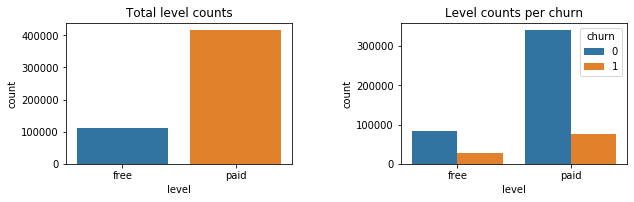

In [43]:
# Plot level
fig, ax = plt.subplots(1, 2)
sns.countplot(x = "level", data = df_pandas[["level", "churn"]], ax = ax[0]).set_title('Total level counts')
g = sns.countplot(x = "level", hue = "churn", data = df_pandas[["level", "churn"]], ax = ax[1])
g.set_title('Level counts per churn')
g.figure.set_figwidth(10)
fig.tight_layout(pad = 5.0)
fig.show()

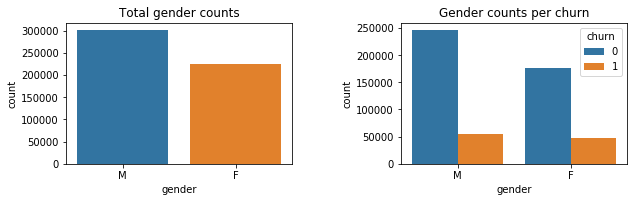

In [44]:
# Plot gender
fig, ax = plt.subplots(1, 2)
sns.countplot(x = "gender", data = df_pandas[["gender", "churn"]], ax = ax[0]).set_title('Total gender counts')
g = sns.countplot(x = "gender", hue = "churn", data = df_pandas[["gender", "churn"]], ax = ax[1])
g.set_title('Gender counts per churn')
g.figure.set_figwidth(10)
fig.tight_layout(pad = 5.0)
fig.show()

In [45]:
# Pandas DF is nt needed anymore here. Allow GC to collect
df_pandas = None

## Transformations and feature preparing

After exploration and visualization, we have a clear understanding of the data and the direction we want to go for engineering features later, so we are ready for some data transformations now. Where approriate and convenient, we will prepare features
that will be placed in our final feature vector.

### One-hot encodings

We will string index the columns level and gender.
Later we will repeat the same for the page events, and finally we will sum the session and length columns.

### level and gender

In [46]:
# We user StringIndexer for these features.
df_raw = StringIndexer(inputCol = "level", outputCol = "level_index") \
    .fit(df_raw).transform(df_raw)

df_raw = df_raw.drop("level")

# Repeat for gender
df_raw = StringIndexer(inputCol = "gender", outputCol = "gender_index") \
    .fit(df_raw).transform(df_raw)

df_raw = df_raw.drop("gender")

### state

In [47]:
# At 448 users, the locations will probably not have a big impact. So we will try collecting users in states, and see how 
# that works out. Here the pyspark function regexp_extract comes in handy.

# The below regular expression matches the format "City, State" and extracts the state.
df_raw = df_raw.withColumn("state", regexp_extract(col("location"), r'^.{1,},\s?([A-Z\-]{2,11})$', 1))

df_raw = df_raw.drop("location")

In [48]:
# How many states are there?
df_raw.select("state").distinct().count()

70

In [49]:
# Do some more visualization: State to churn
df_pandas = df_raw.toPandas()

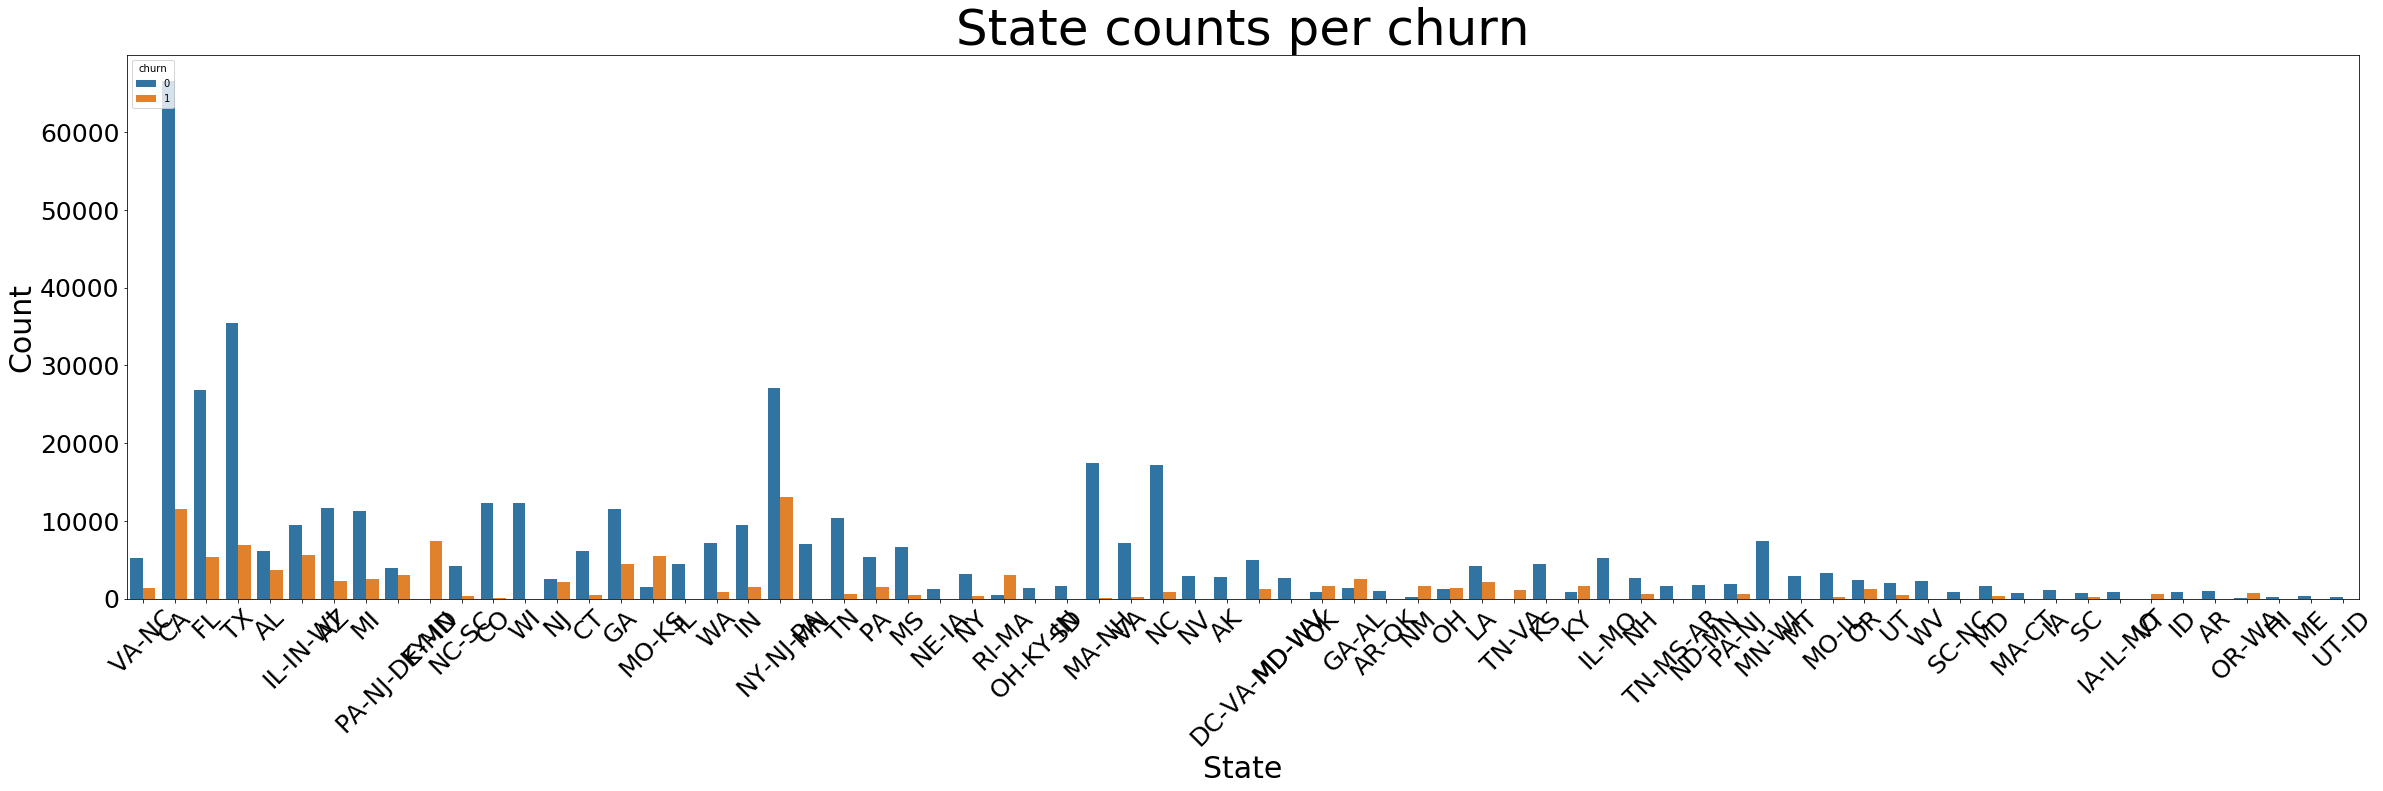

In [50]:
# We have compacted 192 locations to 70 states. Sounds good! 
g = sns.countplot(x = "state", hue = "churn", data = df_pandas[["state", "churn"]])
g.set_title('State counts per churn',fontsize = 50)
g.figure.set_figwidth(40)
g.figure.set_figheight(10)
g.set_xlabel("State",fontsize = 30)
g.set_ylabel("Count",fontsize = 30)
g.tick_params(labelsize = 25)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
fig.show()

In [51]:
# Note: I decided to leave this feature out after all, since there seems to be little correlation and there are some
# aggregated fields like DC-VA-MD-WA. Also it is more effort to recreate the one-hot-encoded value in the web app.
# I left this code in here commented out, as proof of work.

# It looks like there could be some relevance here so we will keep the state column as feature component.
# Since this is non-boolean categorical data we can use a StringIndexer.

#df_raw = StringIndexer(inputCol = "state", outputCol = "state_index") \
#    .fit(df_raw).transform(df_raw)

#df_raw = df_raw.drop("state")

In [52]:
# state is a nominal so we should one-hot encode the state_index column
#df_raw = OneHotEncoder(inputCol = "state_index", outputCol = "state_encoded") \
#    .transform(df_raw)

#df_raw = df_raw.drop("state_index")
df_raw = df_raw.drop("state")

In [53]:
df_raw.show()

+---------+---------------+---------+------+-----+-----------+------------+
|   length|           page|sessionId|userId|churn|level_index|gender_index|
+---------+---------------+---------+------+-----+-----------+------------+
|      0.0|    Roll Advert|      195|   196|    1|        1.0|         0.0|
|277.52444|       NextSong|      195|   196|    1|        1.0|         0.0|
|168.61995|       NextSong|      222|   223|    1|        1.0|         0.0|
|251.55873|       NextSong|      178|   179|    0|        0.0|         0.0|
|168.59383|       NextSong|      418|   127|    0|        0.0|         1.0|
|      0.0|     Add Friend|      245|   246|    1|        0.0|         1.0|
|      0.0|      Thumbs Up|      287|   288|    1|        0.0|         0.0|
|188.08118|       NextSong|      245|   246|    1|        0.0|         1.0|
|180.06159|       NextSong|      492|    95|    0|        0.0|         1.0|
| 192.9922|       NextSong|      526|   293|    1|        1.0|         0.0|
|429.94893| 

### Page events

We select some more page events to include as feature components. I have selected the values:
    
    * Thumbs Up
    * Thumbs Down
    * NextSong 
    * Downgrade

In [54]:
def sumColumn(df, columnToSum, columnSumName):
    """ Calculate the sum of values in the "page" column aggregated by "userId" in the passed column and create a new column.
    INPUT:
        df: The dataframe to perform the operation on.
        columnToSum: Name of the column to sum values for.
        columnSumName: Name of the new column.
    OUTPUT:
        The dataframe with the new column of the summed up values of the old column.
    """
    # Add a column that shows whenever the user clicked a "Thumbs Up"
    df = df.withColumn("temp", when(col("page") == columnToSum, 1).otherwise(0))
    # Add a column that uses the aggregated sum of thumbs up per user and join it back into the main dataset 
    df = df.join(
        df.groupby('userId').agg({"temp": "sum"}).withColumnRenamed("sum(temp)", columnSumName), ["userId"])
    # Drop unnused column
    return df.drop("temp")

In [55]:
df_raw = sumColumn(df_raw, "Thumbs Up", "thumbs_up_sum")
df_raw = sumColumn(df_raw, "Thumbs Down", "thumbs_down_sum")
df_raw = sumColumn(df_raw, "NextSong", "nextsong_sum")
df_raw = sumColumn(df_raw, "Downgrade", "downgrade_sum")

In [56]:
# Now we can get rid of the "page" column.
df_raw = df_raw.drop("page")

In [57]:
df_raw.show()

+------+---------+---------+-----+-----------+------------+-------------+---------------+------------+-------------+
|userId|   length|sessionId|churn|level_index|gender_index|thumbs_up_sum|thumbs_down_sum|nextsong_sum|downgrade_sum|
+------+---------+---------+-----+-----------+------------+-------------+---------------+------------+-------------+
|   148|  257.802|     3208|    0|        1.0|         0.0|           10|              4|         307|            0|
|   148|386.76853|      992|    0|        1.0|         0.0|           10|              4|         307|            0|
|   148|340.63628|      992|    0|        1.0|         0.0|           10|              4|         307|            0|
|   148| 225.2273|     2290|    0|        1.0|         0.0|           10|              4|         307|            0|
|   148|309.99465|     2290|    0|        1.0|         0.0|           10|              4|         307|            0|
|   148|236.12036|      992|    0|        1.0|         0.0|     

### length

We will denormalize the accumulated length info for each user.

In [58]:
df_raw = df_raw.join(
    df_raw.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length_sum"), ["userId"])

df_raw = df_raw.drop("length")

### sessionId

Finally we calculate the sum of unique sessions for each user. This time the function countDistinct is helpful.

In [59]:
df_raw = df_raw.join(
    df_raw.groupby('userId').agg(countDistinct("sessionId")) \
    .withColumnRenamed("count(DISTINCT sessionId)", "sessionId_count"), ["userId"])

df_raw = df_raw.drop("sessionId")

### Transformation and feature preparation result

In [60]:
df_raw.printSchema()
df_raw.show()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- level_index: double (nullable = false)
 |-- gender_index: double (nullable = false)
 |-- thumbs_up_sum: long (nullable = true)
 |-- thumbs_down_sum: long (nullable = true)
 |-- nextsong_sum: long (nullable = true)
 |-- downgrade_sum: long (nullable = true)
 |-- length_sum: double (nullable = true)
 |-- sessionId_count: long (nullable = false)

+------+-----+-----------+------------+-------------+---------------+------------+-------------+-----------------+---------------+
|userId|churn|level_index|gender_index|thumbs_up_sum|thumbs_down_sum|nextsong_sum|downgrade_sum|       length_sum|sessionId_count|
+------+-----+-----------+------------+-------------+---------------+------------+-------------+-----------------+---------------+
|   148|    0|        1.0|         0.0|           10|              4|         307|            0|76207.76939999999|             10|
|   148|    0|        1.0|         0.0|    

## Visualization (Post-Transformation)

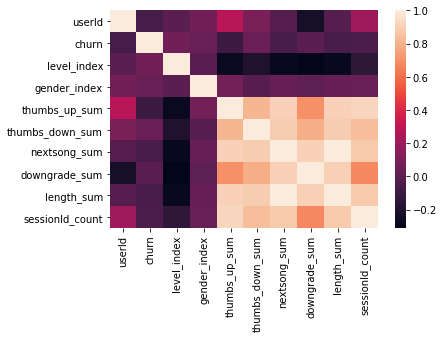

In [61]:
# Calculate correlations and display a heatmap
corr = df_raw.toPandas().corr()
sns.heatmap(corr)

In [62]:
# We see some highly correlated features that were extracted from the "page" event column.

## Export

After all this work it is a good idea to save our progress.
The dataframe will be saved in original form, as well as a feature version (VectorAssembled).
This is also the version we will use for the rest of the project.

In [63]:
# Write original to parquet file
df_raw.write.parquet("out/transformed.parquet")

In [64]:
# Assemble all features into a column
df_raw = VectorAssembler(inputCols = \
                         ["level_index", "gender_index", "thumbs_up_sum", "thumbs_down_sum", "nextsong_sum", "downgrade_sum", \
                          "length_sum", "sessionId_count"], \
                         outputCol = "features").transform(df_raw)

# Drop the unneeded columns
df_raw = df_raw.select("features", "churn")

# Look at the schema
df_raw.printSchema()

root
 |-- features: vector (nullable = true)
 |-- churn: integer (nullable = true)



In [65]:
# Write to parquet file
df_raw.write.parquet("out/features.parquet")

In [66]:
# Output the notebook to an html file
from subprocess import call
call(['python', '-m', 'nbconvert', 'etl-fe.ipynb'])

0